
# ==========================================
# IMPORT LIBRARY & CONNECT DB
# ==========================================


In [16]:
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

%matplotlib inline
sns.set_style("whitegrid")

print("Library siap")

Library siap


In [17]:
def load_data_from_db():
    print("Menghubungkan ke Server 202.10.34.23...")
    try:
        conn = mysql.connector.connect(
            host="202.10.34.23",
            user="root",
            password="AKJWHd898a7wd12@#jhasf",
            database="tubes_dwbi"
        )
        
        query = """
        SELECT 
            f.Transaction_ID, 
            f.Customer_ID, 
            f.Store_ID, 
            f.Quantity, 
            f.Total_Amount,
            c.Age, 
            c.Gender,
            d.Full_Date,
            p.Product_Category
        FROM Fact_Sales f
        LEFT JOIN Dim_Customer c ON f.Customer_ID = c.Customer_ID
        LEFT JOIN Dim_Date d ON f.Date_ID = d.Date_ID
        LEFT JOIN Dim_Product p ON f.Product_ID = p.Product_ID
        """
        
        df = pd.read_sql(query, conn)
        conn.close()
        
        print(f"Berhasil tarik {len(df)} baris data langsung dari Database!")
        return df
        
    except mysql.connector.Error as err:
        print(f"Gagal Connect: {err}")
        return None

df = load_data_from_db()
df.head()

Menghubungkan ke Server 202.10.34.23...
Berhasil tarik 1000 baris data langsung dari Database!


C:\Users\Akhdan\AppData\Local\Temp\ipykernel_16908\756055555.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,Transaction_ID,Customer_ID,Store_ID,Quantity,Total_Amount,Age,Gender,Full_Date,Product_Category
0,1,CUST001,S003,3,150.0,34,Male,2023-11-24,Beauty
1,2,CUST002,S001,2,1000.0,26,Female,2023-02-27,Clothing
2,3,CUST003,S002,1,30.0,50,Male,2023-01-13,Electronics
3,4,CUST004,S004,1,500.0,37,Male,2023-05-21,Clothing
4,5,CUST005,S003,2,100.0,30,Male,2023-05-06,Beauty


# ==========================================
#  BLOK 2: Data Cleaning & Enrichment (ETL)
# ==========================================

In [18]:
if df is not None:
    df['Full_Date'] = pd.to_datetime(df['Full_Date'])
    df['Total_Amount'] = df['Total_Amount'].astype(float)
    df['Quantity'] = df['Quantity'].astype(int)
    
    df = df[df['Full_Date'].dt.year == 2023]
    print(f"Sisa data 2023: {len(df)} transaksi.")
    
    df['Month'] = df['Full_Date'].dt.month
    df['Quarter'] = df['Full_Date'].dt.quarter
    
    store_map = {'S001': 'Bekasi', 'S002': 'Solo', 'S003': 'Jakarta', 'S004': 'Banjarmasin', 'S005': 'Bekasi'}
    df['City'] = df['Store_ID'].map(store_map).fillna('Unknown')
    
    def classify_age(age):
        if age < 25: return 'Young (<25)'
        elif age <= 50: return 'Adult (25-50)'
        else: return 'Senior (>50)'
    df['Age_Group'] = df['Age'].apply(classify_age)
    
    print("ETL Selesai! Kolom baru: City, Age_Group, Quarter")
    display(df.head(3))

Sisa data 2023: 998 transaksi.
ETL Selesai! Kolom baru: City, Age_Group, Quarter


,Transaction_ID,Customer_ID,Store_ID,Quantity,Total_Amount,Age,Gender,Full_Date,Product_Category,Month,Quarter,City,Age_Group
0,1,CUST001,S003,3,150.0,34,Male,2023-11-24,Beauty,11,4,Jakarta,Adult (25-50)
1,2,CUST002,S001,2,1000.0,26,Female,2023-02-27,Clothing,2,1,Bekasi,Adult (25-50)
2,3,CUST003,S002,1,30.0,50,Male,2023-01-13,Electronics,1,1,Solo,Adult (25-50)


# ==========================================
# BLOK 3: AI Clustering (K-Means)
# ==========================================

Clustering Selesai! Lihat sebarannya:
Category
Hemat      700
Reguler    200
Sultan      98
Name: count, dtype: int64


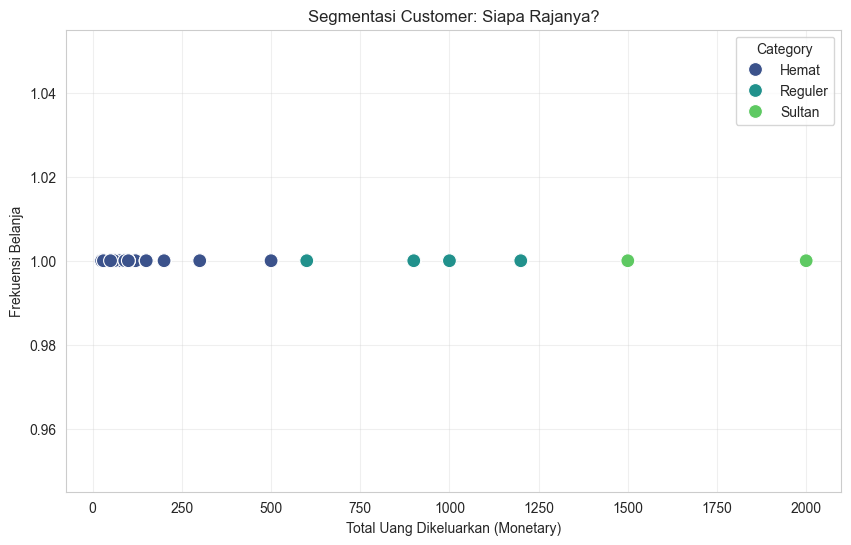

In [19]:
cust_stats = df.groupby('Customer_ID').agg({
    'Total_Amount': 'sum', 
    'Transaction_ID': 'count'
}).reset_index()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(cust_stats[['Total_Amount', 'Transaction_ID']])

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
cust_stats['Cluster'] = kmeans.fit_predict(X_scaled)

cluster_means = cust_stats.groupby('Cluster')['Total_Amount'].mean().sort_values()
labels = ['Hemat', 'Reguler', 'Sultan']
mapping = {k: v for k, v in zip(cluster_means.index, labels)}
cust_stats['Category'] = cust_stats['Cluster'].map(mapping)

df = df.merge(cust_stats[['Customer_ID', 'Category']], on='Customer_ID', how='left')

print("Clustering Selesai! Lihat sebarannya:")
print(df['Category'].value_counts())

plt.figure(figsize=(10, 6))
sns.scatterplot(data=cust_stats, x='Total_Amount', y='Transaction_ID', hue='Category', palette='viridis', s=100)
plt.title('Segmentasi Customer: Siapa Rajanya?')
plt.xlabel('Total Uang Dikeluarkan (Monetary)')
plt.ylabel('Frekuensi Belanja')
plt.grid(True, alpha=0.3)
plt.show()

# ==========================================
# BLOK 4: Forecasting (Prediksi Bulan Depan)
# ==========================================

Prediksi Total Omzet 30 Hari Kedepan: Rp 39,837
Tren Harian: Naik (0.04 per hari)


C:\Users\Akhdan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


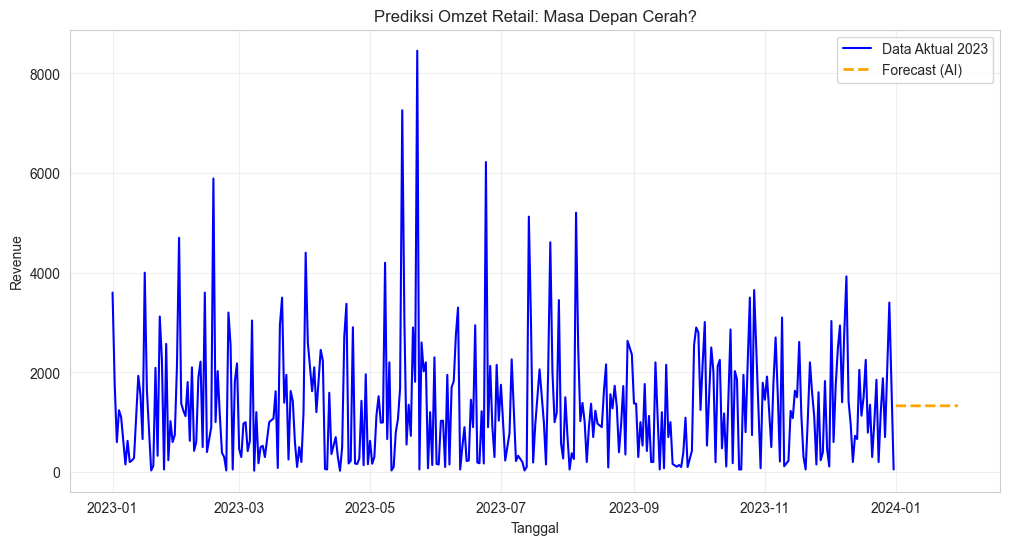

In [20]:
daily_sales = df.groupby('Full_Date')['Total_Amount'].sum().reset_index()
daily_sales['Day_Index'] = range(1, len(daily_sales) + 1)

model = LinearRegression()
model.fit(daily_sales[['Day_Index']], daily_sales['Total_Amount'])

last_day_idx = daily_sales['Day_Index'].max()
future_days = np.array([[last_day_idx + i] for i in range(1, 31)])
forecast_values = model.predict(future_days)

print(f"Prediksi Total Omzet 30 Hari Kedepan: Rp {forecast_values.sum():,.0f}")
print(f"Tren Harian: {'Naik' if model.coef_[0] > 0 else 'Turun'} ({model.coef_[0]:.2f} per hari)")

plt.figure(figsize=(12, 6))
plt.plot(daily_sales['Full_Date'], daily_sales['Total_Amount'], label='Data Aktual 2023', color='blue')
last_date = daily_sales['Full_Date'].iloc[-1]
future_dates = [last_date + pd.Timedelta(days=i) for i in range(1, 31)]
plt.plot(future_dates, forecast_values, label='Forecast (AI)', color='orange', linestyle='--', linewidth=2)

plt.title('Prediksi Omzet Retail: Masa Depan Cerah?')
plt.xlabel('Tanggal')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ==========================================
# BLOK 5: Analisis Gender & Kategori
# ==========================================

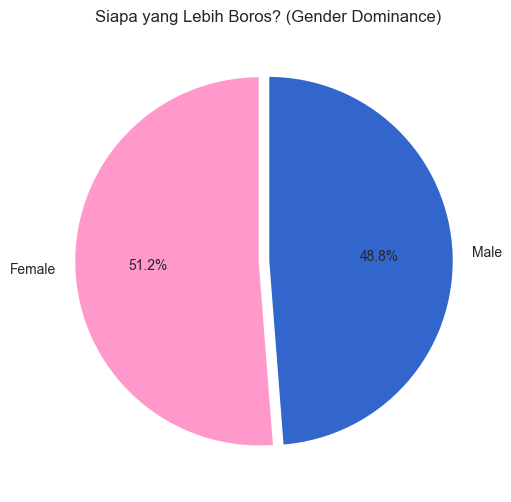

C:\Users\Akhdan\AppData\Local\Temp\ipykernel_16908\2763858782.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cat_stats.values, y=cat_stats.index, palette='magma')


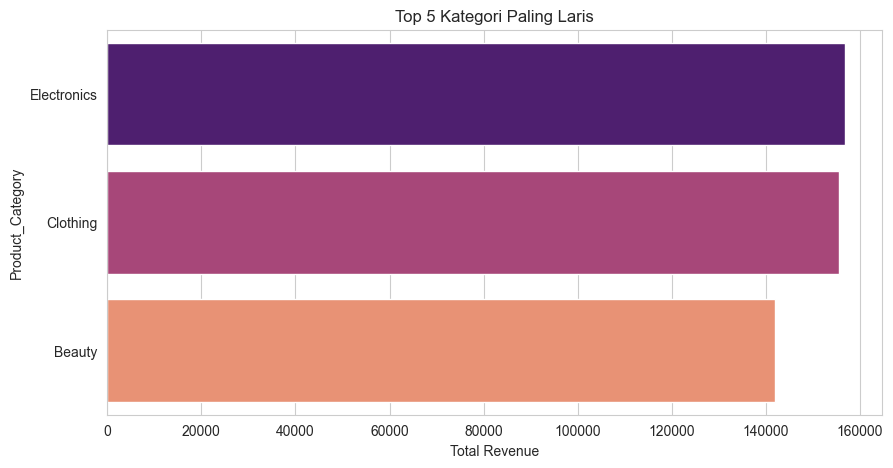

In [21]:
gender_stats = df.groupby('Gender')['Total_Amount'].sum().reset_index()

plt.figure(figsize=(6, 6))
plt.pie(gender_stats['Total_Amount'], labels=gender_stats['Gender'], autopct='%1.1f%%', 
        colors=['#FF99CC', '#3366CC'], startangle=90, explode=(0.05, 0))
plt.title('Siapa yang Lebih Boros? (Gender Dominance)')
plt.show()

cat_stats = df.groupby('Product_Category')['Total_Amount'].sum().sort_values(ascending=False).head(5)
plt.figure(figsize=(10, 5))
sns.barplot(x=cat_stats.values, y=cat_stats.index, palette='magma')
plt.title('Top 5 Kategori Paling Laris')
plt.xlabel('Total Revenue')
plt.show()